In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np 


In [4]:
import tensorflow as tf
tf.__version__

'1.0.0'

## Performance:

- ultra optimal logistic - ~200 Giter/s
- ElementwiseKernel - 10+ Giter/s
- CPU single core - 0.3 Giter/s
- Tensorflow @GPU 5Giter/s  
- Tensorflow @CPU (20cores) 0.5Giter/s  


In [7]:
import pycuda.gpuarray as gpuarray

from pycuda.curandom import rand as curand
from pycuda.compiler import SourceModule
import pycuda.driver as cuda

try:
    ctx.pop()
    ctx.detach()
except:
    print( "No CTX!")

cuda.init()
device = cuda.Device(1)
ctx = device.make_context()


mod = SourceModule("""
    __global__ void logistic_iterations(float *a,float *x,int Niter)
    {
      
      int idx = threadIdx.x + blockDim.x*blockIdx.x;
      float a_ = a[idx];
      float x_ = x[idx];
      int i;
      for (i=0;i<Niter;i++){
        
          x_ = a_*x_*(1-x_);
      }
      
      x[idx] = x_;
    }
    """)
logistic_iterations = mod.get_function("logistic_iterations")

No CTX!


In [25]:
block_size=128
Nx = 1024
Na = 1024
blocks = Nx*Na//block_size

a = np.linspace(3.255,4,Na).astype(np.float32)
a = np.repeat(a,Nx)
x = np.random.rand(Na*Nx).astype(np.float32)

In [26]:
a_gpu = gpuarray.to_gpu(a)
#%time x_gpu = curand((Na*Nx,))
%time x_gpu = gpuarray.to_gpu(x)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.49 ms


In [10]:
%%time
logistic_iterations(a_gpu,x_gpu, np.int32(1000),block=(block_size,1,1), grid=(blocks,1,1))
ctx.synchronize()

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.12 ms


In [27]:
%%time
for i in range(1000):
    logistic_iterations(a_gpu,x_gpu, np.int32(1),block=(block_size,1,1), grid=(blocks,1,1))
ctx.synchronize()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 560 µs


In [12]:
%%time 
for i in range(1000):
    x_gpu = a_gpu*x_gpu*(1-x_gpu)

CPU times: user 516 ms, sys: 732 ms, total: 1.25 s
Wall time: 1.53 s


In [13]:
import numexpr as ne

In [14]:
%%time 
for i in range(1000):
    x = ne.evaluate("a*x*(1-x)")

CPU times: user 5.65 s, sys: 124 ms, total: 5.78 s
Wall time: 968 ms


In [15]:
%%time 
for i in range(1000):
    x = a*x*(1-x)

CPU times: user 1.88 s, sys: 8 ms, total: 1.88 s
Wall time: 1.88 s


In [16]:
%%time 
for i in range(1000):
    x *= (1.0-x)
    x *= a

CPU times: user 1.48 s, sys: 0 ns, total: 1.48 s
Wall time: 1.47 s


In [28]:
a,x = a_gpu.get(),x_gpu.get()

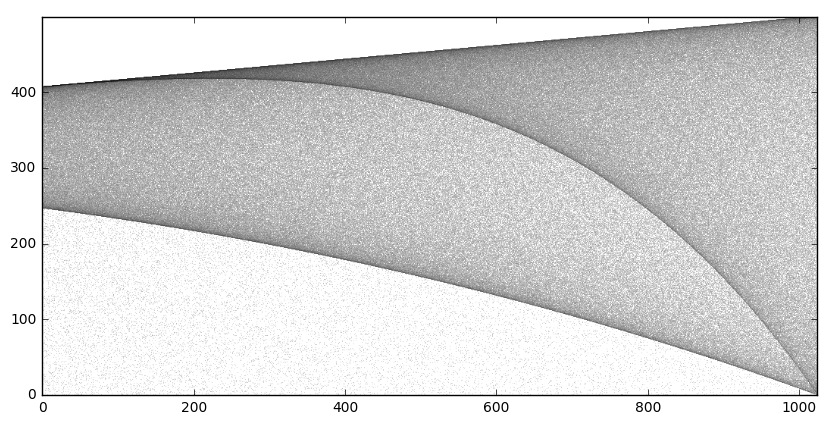

In [29]:
H, xedges, yedges = np.histogram2d(a,x,bins=(Na,500))
plt.figure(num=1, figsize=(10,5))
plt.imshow(1-np.log(H.T+5e-1),origin='lower',cmap='gray')

# Logistic with tf

In [9]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np 

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

Nx = 10240
Na = 1024

a = np.linspace(3.255,4,Na).astype(np.float32)
a = np.repeat(a,Nx)
x = np.random.rand(Na*Nx).astype(np.float32)

### Pętla zewnętrzna 

In [10]:
with tf.device('/gpu:0'):
    X = tf.Variable(x)
    A = tf.constant(a)

    X_ = A*X*(1.0-X)
    step = tf.group( X.assign(X_) ) # ?with or not?

In [11]:
sess = tf.InteractiveSession(config=config)
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [12]:
step = tf.group( X.assign(X_) )

In [13]:
%%time 
for i in range(1000):
    step.run()

CPU times: user 3.25 s, sys: 120 ms, total: 3.37 s
Wall time: 2.76 s


### `tf.while_loop`



In [14]:
with tf.device('/gpu:0'):
    X = tf.Variable(x)
    A = tf.constant(a)

    def c(i,x):
        return  tf.less(i, 1000) 

    def b(i,x):
        x = A*x*(1-x)
        return tf.add(i, 1),x

    r = tf.while_loop(c, b, (tf.constant(0),X))

In [15]:

init_op = tf.global_variables_initializer()
with tf.Session(config=config) as sess:
    sess.run(init_op)
    %time iterations,x = sess.run(r)

CPU times: user 1.8 s, sys: 364 ms, total: 2.17 s
Wall time: 1.94 s


### WRONG !!!!

This creates huuuge graph 
```python
    for i in range(100):
        sess.run( X.assign(X_))
```

## Visualization

In [12]:
H, xedges, yedges = np.histogram2d(a,x,bins=(Na,500))

plt.figure(num=1, figsize=(10,5))
plt.imshow(1-np.log(H.T+5e-1),origin='lower',cmap='gray')